In [9]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
import math

In [2]:
df = pd.read_csv("Anam5final.csv",na_values='\\N',encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   월          8760 non-null   int64  
 1   일          8760 non-null   int64  
 2   대여시간       8760 non-null   int64  
 3   요일         8760 non-null   int64  
 4   이동거리(M)    8760 non-null   float64
 5   이용시간(분)    8760 non-null   float64
 6   이용건수       8760 non-null   float64
 7   기온(°C)     8760 non-null   float64
 8   강수량(mm)    8760 non-null   float64
 9   풍속(m/s)    8760 non-null   float64
 10  풍향(16방위)   8760 non-null   float64
 11  습도(%)      8760 non-null   float64
 12  일조(hr)     8760 non-null   float64
 13  일사(MJ/m2)  8760 non-null   float64
 14  적설(cm)     8760 non-null   float64
 15  전운량(10분위)  8760 non-null   float64
 16  지면온도(°C)   8760 non-null   float64
 17  요일_0       8760 non-null   bool   
 18  요일_1       8760 non-null   bool   
 19  요일_2       8760 non-null   bool   
 20  요일_3    

In [39]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   월          8760 non-null   int64  
 1   대여시간       8760 non-null   int64  
 2   기온(°C)     8760 non-null   float64
 3   강수량(mm)    8760 non-null   float64
 4   풍속(m/s)    8760 non-null   float64
 5   풍향(16방위)   8760 non-null   float64
 6   습도(%)      8760 non-null   float64
 7   일조(hr)     8760 non-null   float64
 8   일사(MJ/m2)  8760 non-null   float64
 9   적설(cm)     8760 non-null   float64
 10  전운량(10분위)  8760 non-null   float64
 11  지면온도(°C)   8760 non-null   float64
 12  요일_0       8760 non-null   bool   
 13  요일_1       8760 non-null   bool   
 14  요일_2       8760 non-null   bool   
 15  요일_3       8760 non-null   bool   
 16  요일_4       8760 non-null   bool   
 17  요일_5       8760 non-null   bool   
 18  요일_6       8760 non-null   bool   
dtypes: bool(7), float64(10), int64(2)
memory usage: 

In [3]:
dayofweek = ["요일_"+str(i) for i in range(7)]
features = ['월', '대여시간', '기온(°C)', '강수량(mm)',
       '풍속(m/s)', '풍향(16방위)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '적설(cm)',
       '전운량(10분위)', '지면온도(°C)'] + dayofweek
X = df[features].values
y = df['이용건수'].values

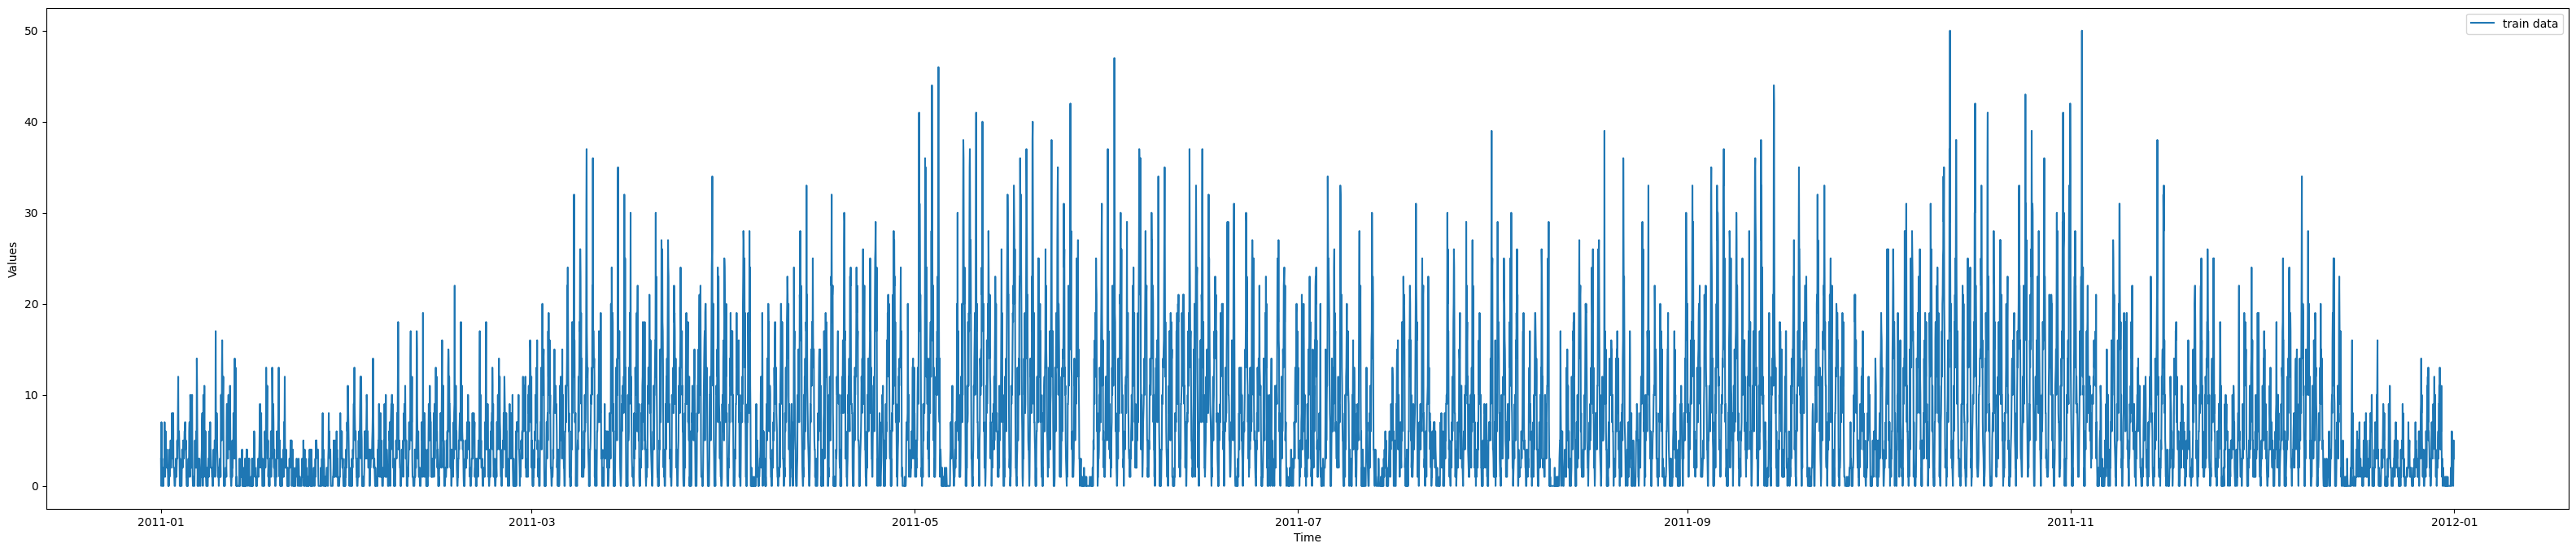

In [17]:
plt.figure(figsize=(40,8))
timestamp = pd.date_range('2011-01-01', periods = 8760, freq='h')
plt.plot(timestamp, y, label = 'train data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [5]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train =X[0:int(8760*0.7),:]
X_test =X[int(8760*0.7+1):,:]
y_train =y[0:int(8760*0.7)]
y_test =y[int(8760*0.7+1):]
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# std_scale = StandardScaler()
minmax_scaler = MinMaxScaler()
minmay_scaler = MinMaxScaler()

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.fit_transform(X_test)

y_train = minmay_scaler.fit_transform(y_train)
y_test = minmay_scaler.fit_transform(y_test)

# std_scale.fit(X_train)
# X_train = std_scale.transform(X_train)
# X_test = std_scale.transform(X_test)

In [22]:
## 04. Parameter optimization (Bayesian optimization)
xgb_run = xgb.XGBRegressor(random_state=0, n_jobs=-1)
xgb_run.get_params()

def bo_params_xgb(max_depth, colsample_bytree, colsample_bylevel, colsample_bynode, gamma, learning_rate, n_estimators, subsample, min_child_weight,base_score):
    params = {'max_depth': int(max_depth),
              'colsample_bytree': colsample_bytree,
              'colsample_bylevel': colsample_bylevel,
              'colsample_bynode': colsample_bynode,
              'gamma': int(gamma),
              'learning_rate': learning_rate,
              'n_estimators': int(n_estimators),
              'subsample':subsample,
              'min_child_weight':min_child_weight,
              'base_score':base_score
             }
    reg = xgb.XGBRegressor(random_state=0,
                           max_depth=params['max_depth'],
                           colsample_bytree=params['colsample_bytree'],
                           colsample_bylevel=params['colsample_bylevel'],
                           colsample_bynode=params['colsample_bynode' ],
                           gamma=params['gamma'],
                           learning_rate=params['learning_rate'],
                           n_estimators=params['n_estimators'],
                           subsample=params['subsample'],
                           min_child_weight=params['min_child_weight'],
                           base_score=params['base_score'],
                           reg_alpha=0.5,
                           reg_lambda=1)
    reg.fit(X_train, y_train)
    preds = reg.predict(X_train)
    score = np.sqrt(mean_squared_error(y_train, preds))
    return - score
xgb_BO = BayesianOptimization(bo_params_xgb, {'max_depth': (1,20),
                                              'colsample_bytree': (0.1,1.0),
                                              'colsample_bylevel': (0.1,1.0),
                                              'colsample_bynode': (0.1,1.0),
                                              'gamma': (0,3),
                                              'learning_rate': (0.0001,0.1),
                                              'n_estimators': (100, 2000),
                                              'subsample': (0.1,1),
                                              'min_child_weight': (0,10),
                                              'base_score':(0.00001,0.3)})
results = xgb_BO.maximize(n_iter=100)
#results = xgb_BO.maximize(n_iter=100, init_points=10,acq='ei')
params = xgb_BO.max['params']
params['max_depth']= int(params['max_depth'])
params['gamma']= int(params['gamma'])
params['n_estimators']= int(params['n_estimators'])
print('Optimum hyper parameter:', params)

|   iter    |  target   | base_s... | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.1571   | 0.04721   | 0.4478    | 0.9387    | 0.4031    | 0.1047    | 0.003929  | 1.451     | 2.318     | 173.5     | 0.4934    |
| 2         | -0.08901  | 0.2518    | 0.9271    | 0.5851    | 0.9832    | 1.437     | 0.04465   | 4.027     | 0.5834    | 988.7     | 0.9784    |
| 3         | -0.09758  | 0.05789   | 0.2204    | 0.4167    | 0.9534    | 1.108     | 0.07271   | 8.186     | 6.872     | 732.9     | 0.5066    |
| 4         | -0.1035   | 0.1906    | 0.898     | 0.222     | 0.3737    | 2.342     | 0.01712   | 11.7      | 1.33      | 1.896e+03 | 0.6411    |
| 5         | -0.09971  | 0.09605   | 0.8384    | 0.8933    | 0.2852    | 1.768     | 0.05301   | 8.623     | 8.442     | 1.

In [23]:
xgb_run = xgb.XGBRegressor(
    max_depth=params['max_depth'],
    colsample_bytree=params['colsample_bytree'],
    colsample_bylevel=params['colsample_bylevel'],
    colsample_bynode=params['colsample_bynode' ],
    gamma=params['gamma'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators'],
    subsample=params['subsample'],
    min_child_weight=params['min_child_weight'],
    base_score=params['base_score'],
    tree_method = 'hist',
    reg_alpha = 0.5,
    reg_lambda = 1)
eval_set = [(X_test, y_test)]
xgb_run.fit(X_train, y_train, early_stopping_rounds= 50,  eval_set=eval_set)

[0]	validation_0-rmse:0.17149
[1]	validation_0-rmse:0.16185
[2]	validation_0-rmse:0.15189
[3]	validation_0-rmse:0.14461
[4]	validation_0-rmse:0.13744
[5]	validation_0-rmse:0.13138
[6]	validation_0-rmse:0.12607
[7]	validation_0-rmse:0.12146
[8]	validation_0-rmse:0.11829
[9]	validation_0-rmse:0.11455
[10]	validation_0-rmse:0.11144
[11]	validation_0-rmse:0.10862
[12]	validation_0-rmse:0.10611
[13]	validation_0-rmse:0.10472
[14]	validation_0-rmse:0.10301
[15]	validation_0-rmse:0.10155
[16]	validation_0-rmse:0.10041
[17]	validation_0-rmse:0.09904
[18]	validation_0-rmse:0.09800
[19]	validation_0-rmse:0.09719
[20]	validation_0-rmse:0.09693
[21]	validation_0-rmse:0.09639
[22]	validation_0-rmse:0.09586
[23]	validation_0-rmse:0.09549
[24]	validation_0-rmse:0.09494
[25]	validation_0-rmse:0.09464
[26]	validation_0-rmse:0.09454
[27]	validation_0-rmse:0.09443
[28]	validation_0-rmse:0.09423
[29]	validation_0-rmse:0.09412
[30]	validation_0-rmse:0.09385
[31]	validation_0-rmse:0.09363
[32]	validation_0-

C:\Users\USER\anaconda3\envs\pythonProject\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-rmse:0.09189
[46]	validation_0-rmse:0.09188
[47]	validation_0-rmse:0.09184
[48]	validation_0-rmse:0.09187
[49]	validation_0-rmse:0.09178
[50]	validation_0-rmse:0.09179
[51]	validation_0-rmse:0.09180
[52]	validation_0-rmse:0.09185
[53]	validation_0-rmse:0.09179
[54]	validation_0-rmse:0.09182
[55]	validation_0-rmse:0.09171
[56]	validation_0-rmse:0.09171
[57]	validation_0-rmse:0.09176
[58]	validation_0-rmse:0.09174
[59]	validation_0-rmse:0.09170
[60]	validation_0-rmse:0.09164
[61]	validation_0-rmse:0.09159
[62]	validation_0-rmse:0.09155
[63]	validation_0-rmse:0.09161
[64]	validation_0-rmse:0.09166
[65]	validation_0-rmse:0.09157
[66]	validation_0-rmse:0.09159
[67]	validation_0-rmse:0.09164
[68]	validation_0-rmse:0.09166
[69]	validation_0-rmse:0.09171
[70]	validation_0-rmse:0.09172
[71]	validation_0-rmse:0.09181
[72]	validation_0-rmse:0.09172
[73]	validation_0-rmse:0.09178
[74]	validation_0-rmse:0.09176
[75]	validation_0-rmse:0.09172
[76]	validation_0-rmse:0.09175
[77]	val

XGBRegressor(base_score=0.05680488266433087, booster=None, callbacks=None,
             colsample_bylevel=0.9234146797048779,
             colsample_bynode=0.9581429899321715,
             colsample_bytree=0.9677287623763233, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08933944583558313, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=2.890131817996581, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=990,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [24]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
xgb_run.fit(X_train, y_train)
scores = cross_val_score(xgb_run, X_train, y_train, scoring='neg_mean_absolute_error', cv=kfold, n_jobs=-1)
train_predict = cross_val_predict(xgb_run,X_train,y_train,cv=kfold)
test_predict = cross_val_predict(xgb_run,X_test,y_test,cv=kfold)

In [29]:
print("train RMSE:{}".format(math.sqrt(mean_squared_error(train_predict, y_train))))
print("test RMSE:{}".format(math.sqrt(mean_squared_error(test_predict, y_test))))

train RMSE:0.07601238385145334
test RMSE:0.07769746713169344


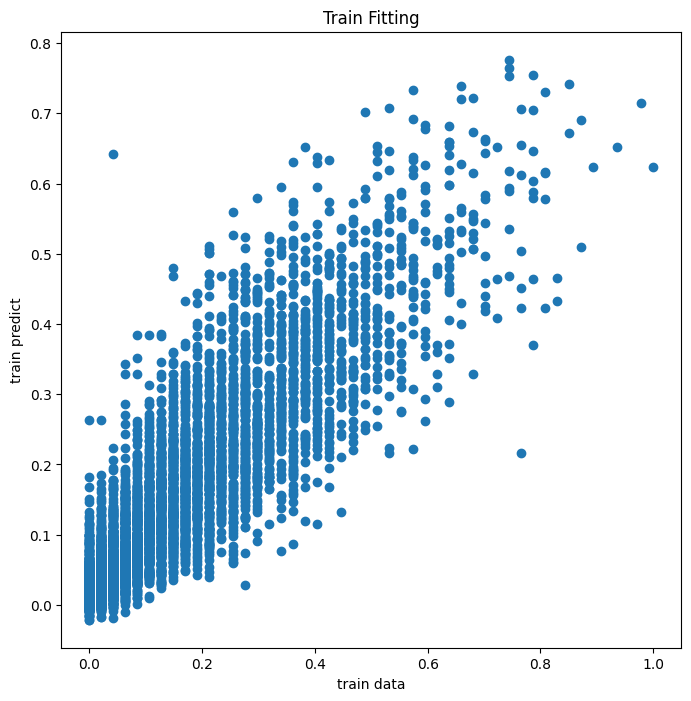

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(y_train,train_predict)
plt.title('Train Fitting')
plt.xlabel('train data', fontsize = 10)
plt.ylabel('train predict', fontsize = 10)
plt.show()

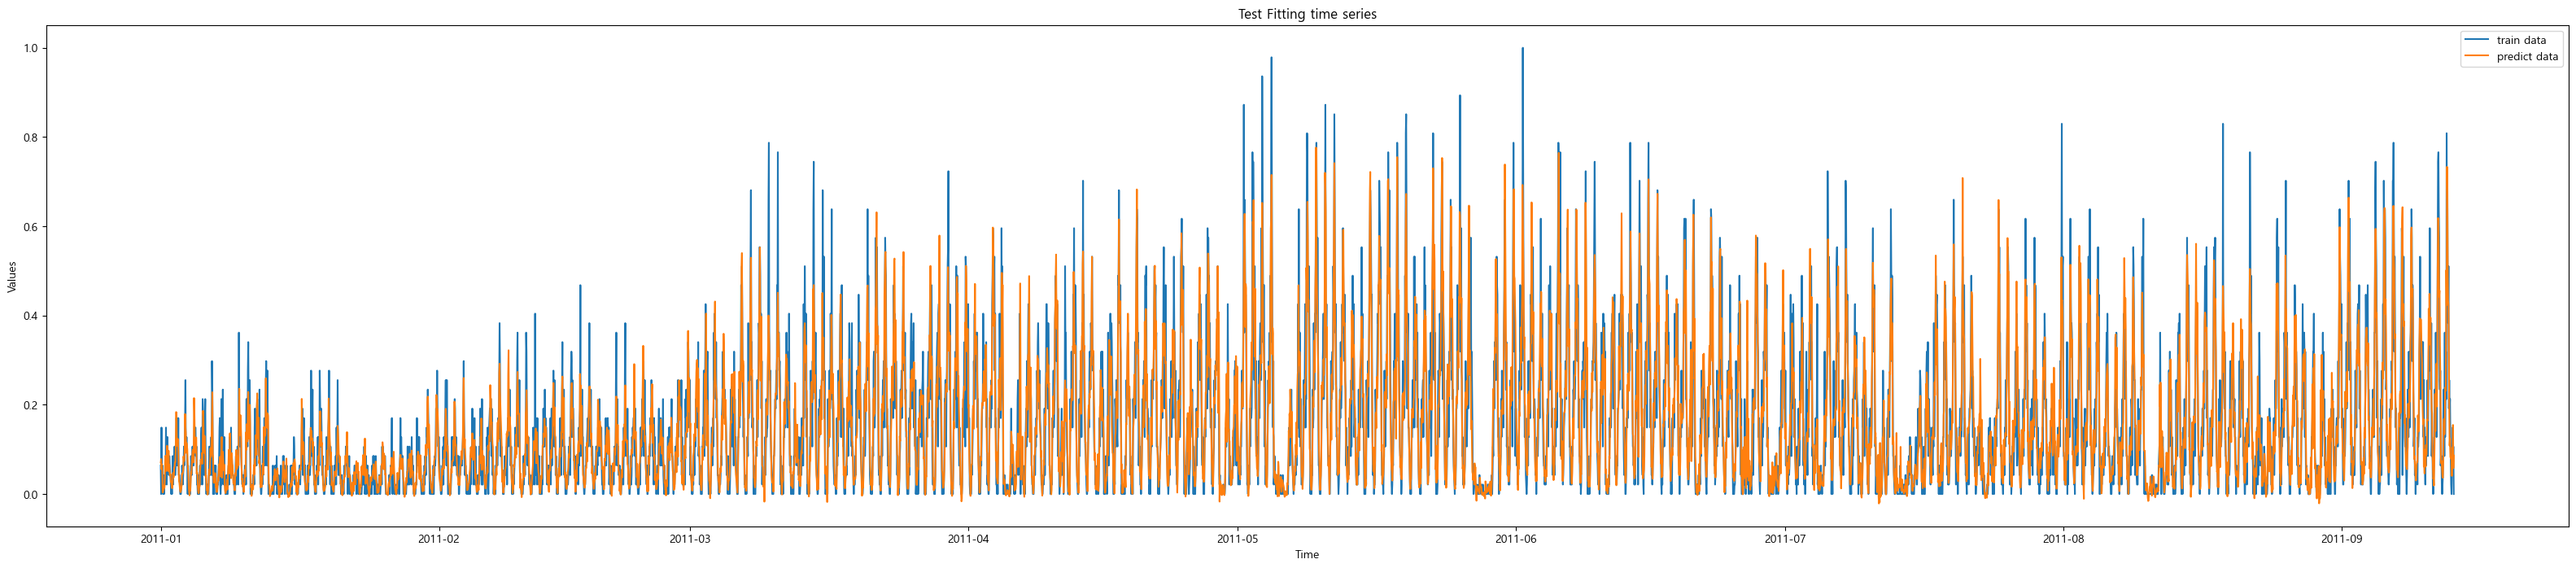

In [45]:
plt.figure(figsize=(40,8))
timestamp = pd.date_range('2011-01-01', periods = 6132, freq='h')
plt.plot(timestamp, y_train, label = 'train data')
plt.plot(timestamp, train_predict, label = 'predict data')
plt.title('Test Fitting time series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

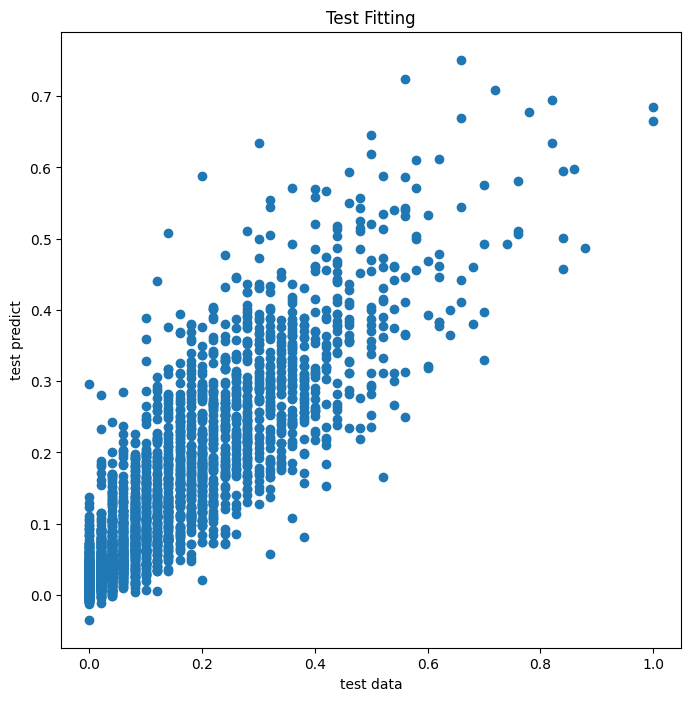

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,test_predict)
plt.title('Test Fitting')
plt.xlabel('test data', fontsize = 10)
plt.ylabel('test predict', fontsize = 10)
plt.show()

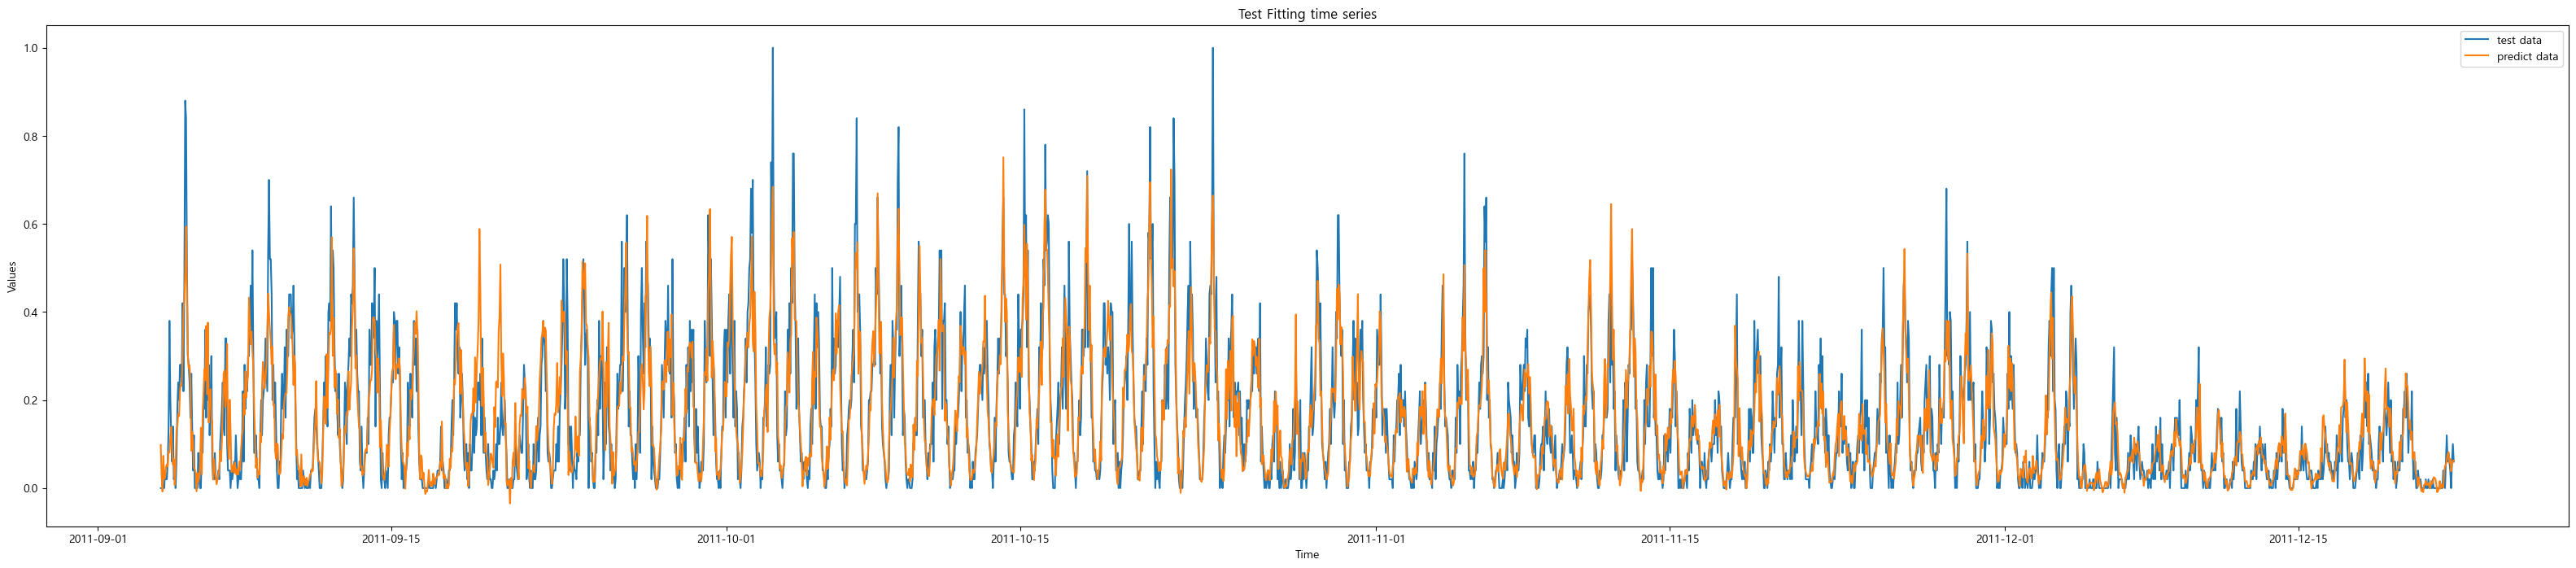

In [46]:
plt.figure(figsize=(40,8))
timestamp = pd.date_range('2011-09-04', periods = 2627, freq='h')
plt.title('Test Fitting time series')
plt.plot(timestamp, y_test, label = 'test data')
plt.plot(timestamp, test_predict, label = 'predict data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [88]:
explainer = shap.Explainer(xgb_run, X_train)
shap_values = explainer(X_train)

100%|===================| 6122/6132 [07:54<00:00]        

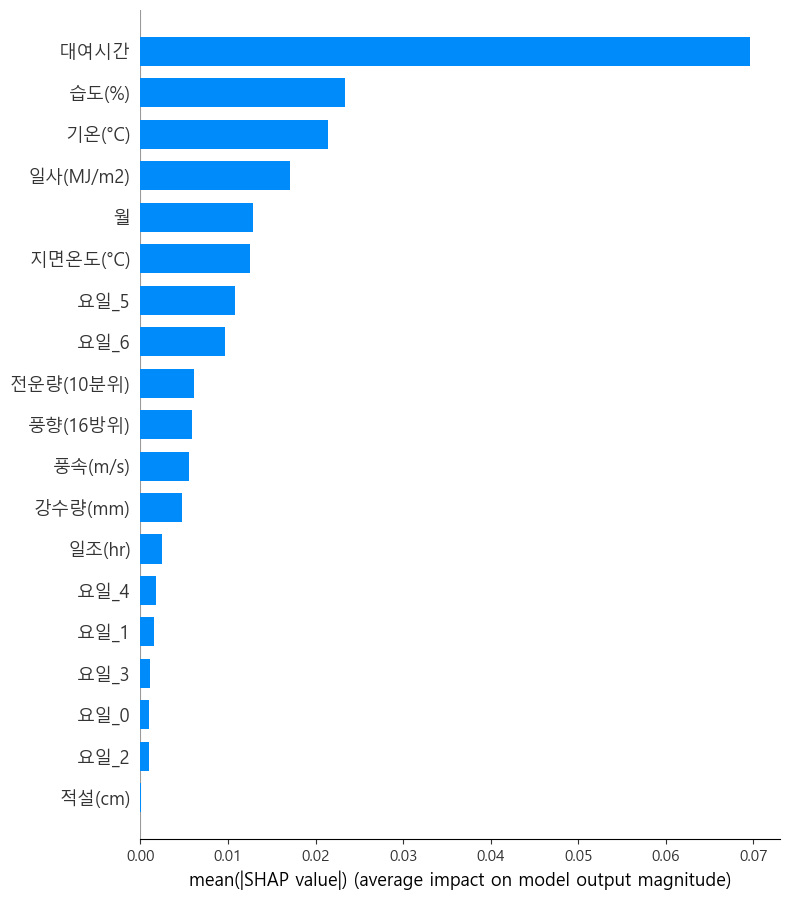

In [89]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train, feature_names=list(df[features].columns), plot_type='bar')
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()

In [90]:
def combine_one_hot(shap_values, name, mask, return_original=True):
    """  shap_values: an Explanation object
          name: name of new feature
          mask: bool array same lenght as features

         This function assumes that shap_values[:, mask] make up a one-hot-encoded feature
    """
    mask = np.array(mask)
    mask_col_names = np.array(shap_values.feature_names, dtype='object')[mask]

    sv_name = shap.Explanation(shap_values.values[:, mask],
                               feature_names=list(mask_col_names),
                               data=shap_values.data[:, mask],
                               base_values=shap_values.base_values,
                               display_data=shap_values.display_data,
                               instance_names=shap_values.instance_names,
                               output_names=shap_values.output_names,
                               output_indexes=shap_values.output_indexes,
                               lower_bounds=shap_values.lower_bounds,
                               upper_bounds=shap_values.upper_bounds,
                               main_effects=shap_values.main_effects,
                               hierarchical_values=shap_values.hierarchical_values,
                               clustering=shap_values.clustering,
                               )

    new_data = (sv_name.data * np.arange(sum(mask))).sum(axis=1).astype(int)

    svdata = np.concatenate([
        shap_values.data[:, ~mask],
        new_data.reshape(-1, 1)
    ], axis=1)

    if shap_values.display_data is None:
        svdd = shap_values.data[:, ~mask]
    else:
        svdd = shap_values.display_data[:, ~mask]

    svdisplay_data = np.concatenate([
        svdd,
        mask_col_names[new_data].reshape(-1, 1)
    ], axis=1)

    new_values = sv_name.values.sum(axis=1)
    svvalues = np.concatenate([
        shap_values.values[:, ~mask],
        new_values.reshape(-1, 1)
    ], axis=1)
    svfeature_names = list(np.array(shap_values.feature_names)[~mask]) + [name]

    sv = shap.Explanation(svvalues,
                          base_values=shap_values.base_values,
                          data=svdata,
                          display_data=svdisplay_data,
                          instance_names=shap_values.instance_names,
                          feature_names=svfeature_names,
                          output_names=shap_values.output_names,
                          output_indexes=shap_values.output_indexes,
                          lower_bounds=shap_values.lower_bounds,
                          upper_bounds=shap_values.upper_bounds,
                          main_effects=shap_values.main_effects,
                          hierarchical_values=shap_values.hierarchical_values,
                          clustering=shap_values.clustering,
                          )
    if return_original:
        return sv, sv_name
    else:
        return sv

C:\Users\USER\anaconda3\envs\pythonProject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


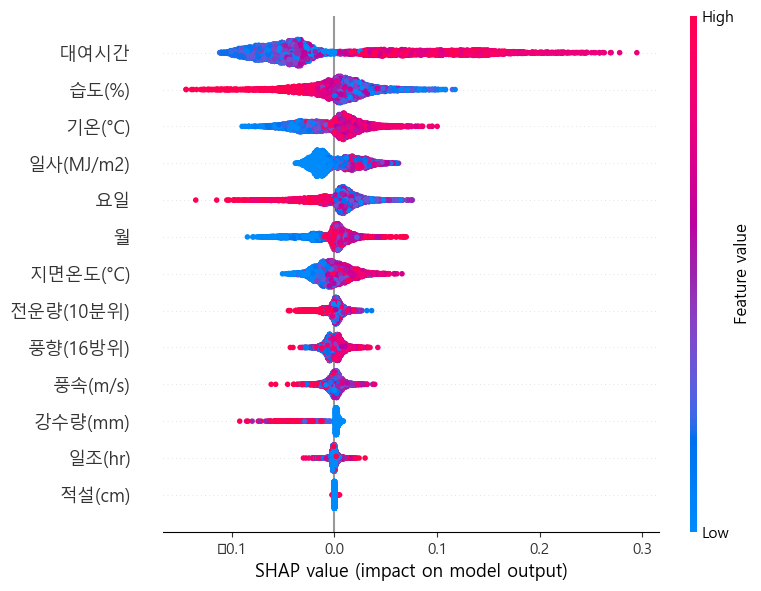

In [91]:
shap_values.feature_names = list(df[features].columns)
shap_values2,sv_occ = combine_one_hot(shap_values,'요일', ['요일' in n for n in list(df[features].columns)])
shap.plots.beeswarm(shap_values2, max_display=20)